# Starbucks Customer Data (Data Understanding)

This notebook has been created to gain an initial data understanding of the datasets provided by Starbucks on their customer behaviour in the context of their incentivised marketing campagins. It will specifically address what data points they have provided, any missing data or how they could be used in terms of predicting future marketing efforts.

The files looked at in this notebook are:
- portfolio.json: containing offer ids and meta data about each offer (duration, type, etc.)
- profile.json: demographic data for each customer
- transcript.json: records for transactions, offers received, offers viewed, and offers completed

### Imports

In [1]:
import pandas as pd
import numpy as np
import json

# plotting functions
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import matplotlib.style as style

### Functions

In [2]:
def plot_histogram(data, column, ax, binsize=50, y_label='', x_label='', color='blue'):
    """
    Function to plot standard histograms (Can be used for individual or side by side plots)
    """
    # Plots the Graph with title & axis
    sns.distplot(data[column], kde=False, color=color, bins=binsize, ax=ax)
    
    # Sets up the title based the column    
    ax.set_title(f"Spread of {column}", fontsize=25)
    
    # Sets the y and x labels
    ax.set_ylabel(y_label, fontsize=24)
    ax.set_xlabel(x_label, fontsize=24)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
        
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    
    # Removes spines and changes layout to tight
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def plot_line(data, ax, color, alpha=.7, ls='-', lw=5, label=None):
    """
    plots the standard line graph
    """
    ax.plot(data, color=color,
            alpha=alpha, ls=ls,
            linewidth=lw, label=label)

### Global Variables

The first thing I will do is load in each of the data files and look at which variables they each contain to gain some understanding of each of the datasets:

In [3]:
# read in each of the data files & look at the variables involved
portfolio_df = pd.read_json('data/portfolio.json', lines=True)
portfolio_df.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
profile_df = pd.read_json('data/profile.json', lines=True)
profile_df.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript_df = pd.read_json('data/transcript.json', lines=True)
transcript_df.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


### Initial Analysis

Next I will perform some initial analysis this will just be very basic to check missing data, values in each column etc and will provide the basis for the processing in the next step of the process. It will also allow me to start planning how I will progress with the project in terms of processing and modeling in the next few notebooks.

#### Portfolio data

First I will get a very basic overview of all of the variables of the portfolio dataset. This dataset contains information on all of the offers ran by Starbucks in the observation period.

In [6]:
# First I'll look at the shape portfolio data
portfolio_df.shape

(10, 6)

In [7]:
# look into the types of offers available
portfolio_df['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [8]:
# look into the spread of the numerical data difficulty, duration & reward
portfolio_df.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [9]:
# find all the differenr types of channels that the campagins were displayed on
portfolio_df.channels

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

From the above analysis I can see that 10 different campaigns where ran with three different types of offer deployed these were bogo (Buy One Get One Free), informational and discounts. They were distributed across the web, email, mobile and social media. They ranged in length between 10 and 3 days. Had an average difficulty (minimum spend) of 8.5 dollars and an average reward of 4 dollars.

#### Profile data

Next I will look at the user profile data to see what information we have on individual consumers.

In [10]:
profile_df.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [11]:
# see how many consumers are in the profile dataset
profile_df.shape

(17000, 5)

In [12]:
# check the spread of ages and income in the data
profile_df.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [13]:
# check spread of data in the gender column
profile_df.groupby('gender').count()

,age,became_member_on,id,income
gender,,,,
F,6129,6129,6129,6129
M,8484,8484,8484,8484
O,212,212,212,212


In [14]:
# check the spread of dates from when users became a member
pd.to_datetime(profile_df['became_member_on']).describe()

count                             17000
unique                             1716
top       1970-01-01 00:00:00.020171207
freq                                 43
first     1970-01-01 00:00:00.020130729
last      1970-01-01 00:00:00.020180726
Name: became_member_on, dtype: object

In [15]:
# see how many missing values are in the income column
profile_df['income'].isna().sum()

2175

/Users/warwick.rommelrath/.pyenv/versions/3.7.5/envs/datastuff/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/warwick.rommelrath/.pyenv/versions/3.7.5/envs/datastuff/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


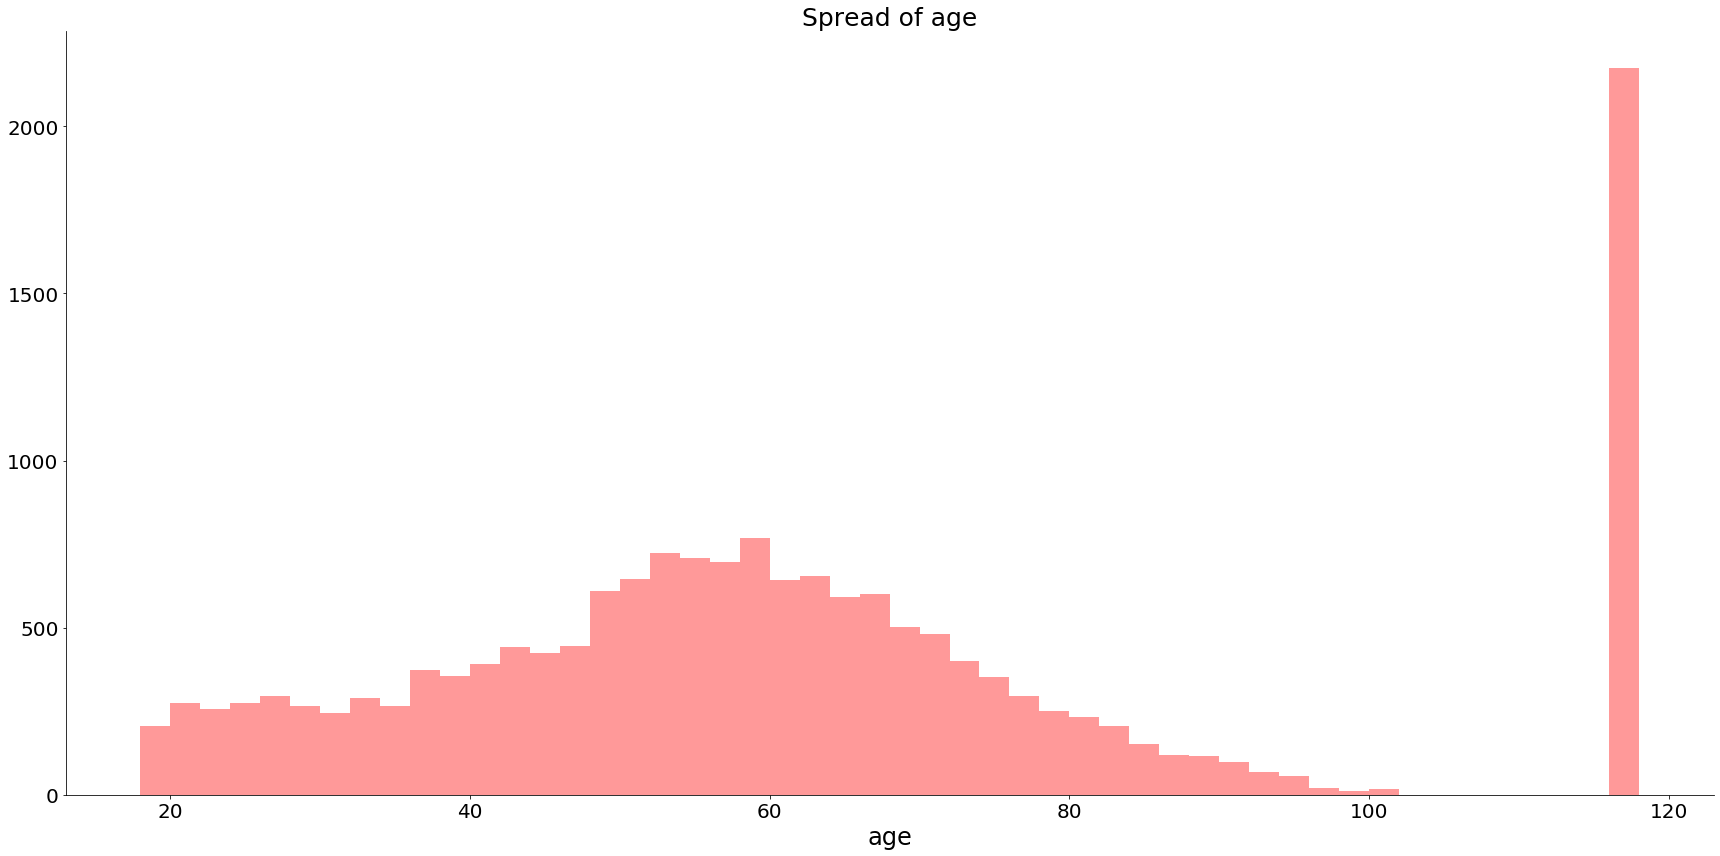

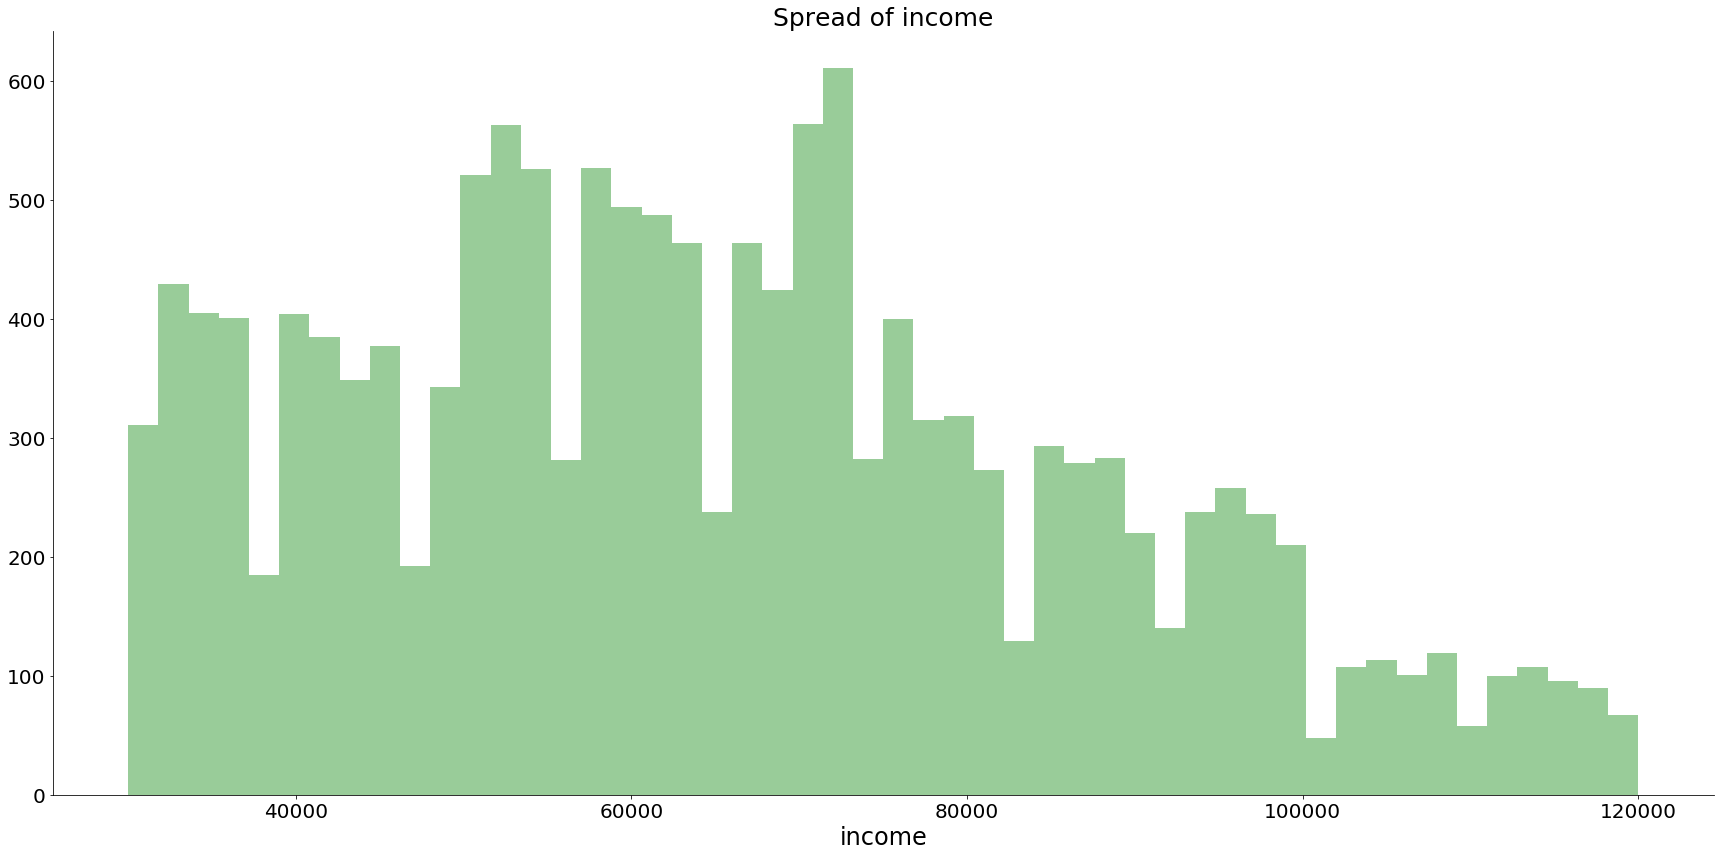

In [16]:
columns = ['age','income']
colors = ['red','green']

# plot histograms to visually show the spread of data
for column in columns:
    # Setup the graphs and add the main title
    fig, ax1 = plt.subplots(figsize=(24,12))

    # Plots the Seattle Graph with title & axis
    plot_histogram(profile_df, column, ax1, binsize=50, 
                   x_label=f'{column}', color=colors[columns.index(column)])

    plt.tight_layout()

From the profile data I can see that their are 17,000 consumers in the dataset with ~6100 female, ~8400 male and ~200 unknown. The users joined between 29th July 2013 and 26th July 2018. We have data on around 15,000 of the users that have an income between 30,000-120,000 with the average of 64,000. The ages range from 18 to greater than 73 however it seems that no age has been specified as for some and instead has been set at 118, this could be users who are more aware of sharing personal data. It is would be worth removing this when running the analysis and either zeroing them so that they are treated as there own dataset or adding a dummy value for the average age.

#### Transcript data

Finally, I will look at the transcript data that contains information on all of the transactions throughout the 30 day period.

In [17]:
transcript_df.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [18]:
# how many interactions have been encountered
transcript_df.shape

(306534, 4)

In [19]:
# look into how the time column is formatted/the spread of the data
transcript_df.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [20]:
# see how many people received the offers and how many didn't
transcript_df.groupby('event').count()

,person,time,value
event,,,
offer completed,33579,33579,33579
offer received,76277,76277,76277
offer viewed,57725,57725,57725
transaction,138953,138953,138953


In [21]:
# number of unique users in the dataset
len(transcript_df['person'].unique())

17000

In [22]:
# see if there is any missing data in the dataset
transcript_df.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [23]:
# look at the values column
transcript_df_copy = transcript_df
transcript_df_copy['type'] = [list(x.keys())[0] for x in transcript_df['value']]
transcript_df_copy['campaign'] = [list(x.values())[0] for x in transcript_df['value']]
transcript_df_copy.groupby('type').count()

,event,person,time,value,campaign
type,,,,,
amount,138953,138953,138953,138953,138953
offer id,134002,134002,134002,134002,134002
offer_id,33579,33579,33579,33579,33579


Frome the transcript data we can see that 306,534 events have been logged by starbucks and the majority of these (138,953) are transactions, with ~76000 offers received, ~58,00 viewed and 33,579 completed. The time column ranges from zero to 714 minutes and shows the time throughout the observation period with a max of around 30 days as expected. The dataset contains all of the 17,000 users that are in the profile data. The value column contains either the campagin ids or the amount spent on the transactions processed.

### Next steps

Now that we have a basic level of understanding of the core input datasets it's possible to plan out the processing and modeling stages of the project in a little bit more depth. As the aim of the project is to perform demographics clustering and regression modeling to predict spend I Will need to create two core input datasets for the modeling. 

The first dataset will be for the demographic grouping and will need to be made from the profile data to get background information on the user but also spend so we can see what the user normally is spending. To gain this spend I will also have to flag the difference between transfers that have been influenced by offers and ones that haven't so I can see normal user behaviour. This should probably be the first step.

For the second dataset we have a number of options of trying to predict spend by day or by transaction. Trying to predict spend by transaction presents a more difficult problem of actually predicting the probability of a transaction actually happening. With this dataset that would be difficult as I only have 30 days of data and all of the marketing overlaps meaning a baseline of if a user will make a transaction or not would have to be made on very limited data. Therefore in this modeling I will assume that I know the transactions that will be influenced and create my modeling off the back of that. The input dataset therefore should have the spend and if any transactions where influenced on that given day. From this we can predict the increase in spend and how successful the marketing models are.

In the next section I will work on creating the above input datasets.